Suvin Seal
<br>
CSI 394
<br>
Finals - Problem 2

#### Libraries for linear algebra and data manipulation

In [1]:
import numpy as np
import pandas as pd

#### Libraries for Data visualization

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_csv("calculus_pretest_data.csv")

In [4]:
df.tail()

,PreCalc Pretest,Algebra Pretest,Course Term,Student Year,Calc Grade
636,NaN,NaN,17/SP,SR,A
637,NaN,NaN,17/SP,FR,A
638,NaN,NaN,17/SP,FR,D-
639,NaN,NaN,17/SP,FR,B-
640,NaN,NaN,17/SP,SO,A


#### Displaying all the rows with null values 

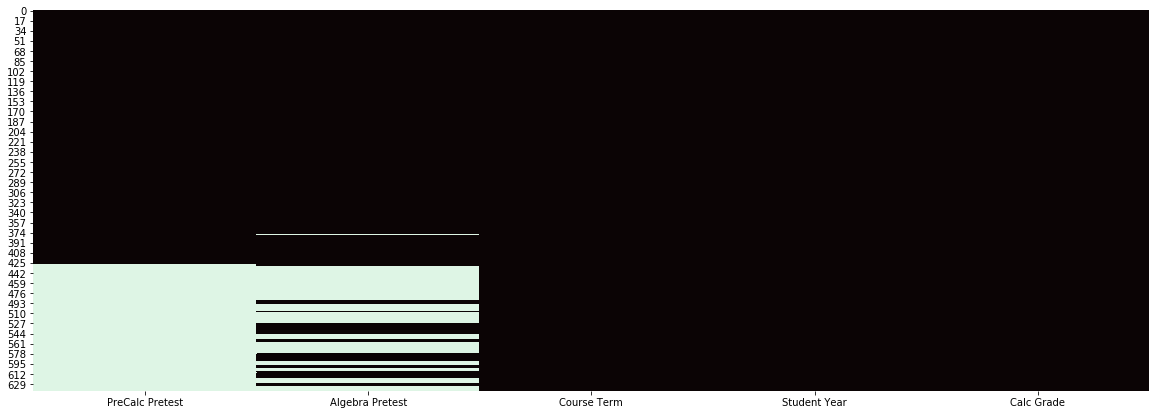

In [5]:
plt.figure(figsize=(20,7))
# blue represents all the NULL rows in DataFrame
sns.heatmap(df.isnull(), cmap = 'mako', cbar = False)

In [6]:
df.columns

Index(['PreCalc Pretest', 'Algebra Pretest', 'Course Term', 'Student Year',
       'Calc Grade'],
      dtype='object')

##### Changing the column name for algebra pretest and calc grade for using these columns to manipulate data in the dataframe

In [7]:
df.columns = ['PreCalc Pretest', 'algebraPretest', 'Course Term', 'Student Year',
       'calcGrade']

##### As there are too many null values in PreCalc Pretest, Getting rid of all null values from PreCalc pretest would be the best way to preapre a dataframe before putting values in a machine learning model

In [8]:
df.dropna(subset = ['PreCalc Pretest'], inplace = True)

In [9]:
df.tail(5)

,PreCalc Pretest,algebraPretest,Course Term,Student Year,calcGrade
423,14.0,81.0,17/SP,FR,C+
424,14.0,68.0,17/SP,FR,F
425,7.0,19.0,14/SP,FR,B-
426,7.0,74.0,17/FA,SO,D-
427,4.0,65.0,16/SP,SO,W


#### Let's visualize the distribution of students on Precalc test depending on the calcGrade

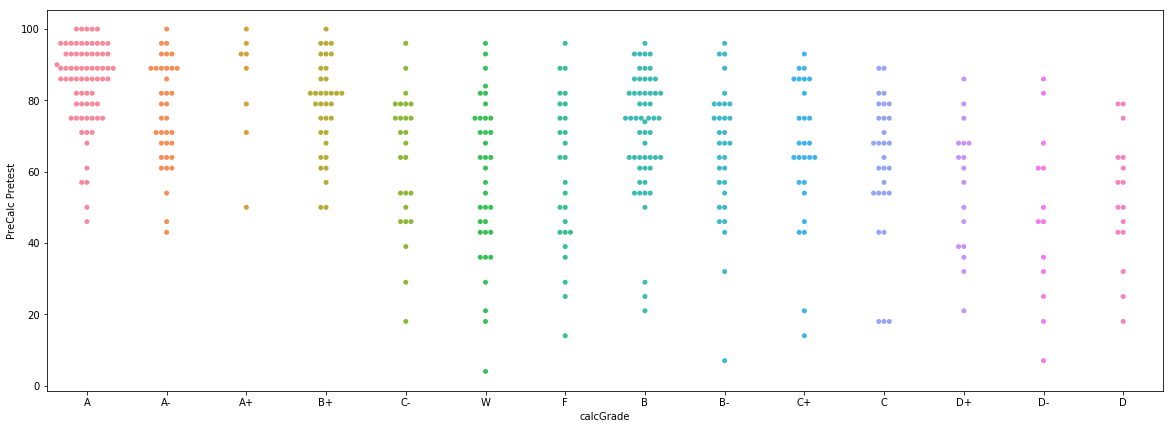

In [10]:
plt.figure(figsize=(20,7))
sns.swarmplot(x='calcGrade', y = 'PreCalc Pretest', data = df) 

#### Visualizing the dataframe after deleting all the rows with null values on PreCalc PreTest

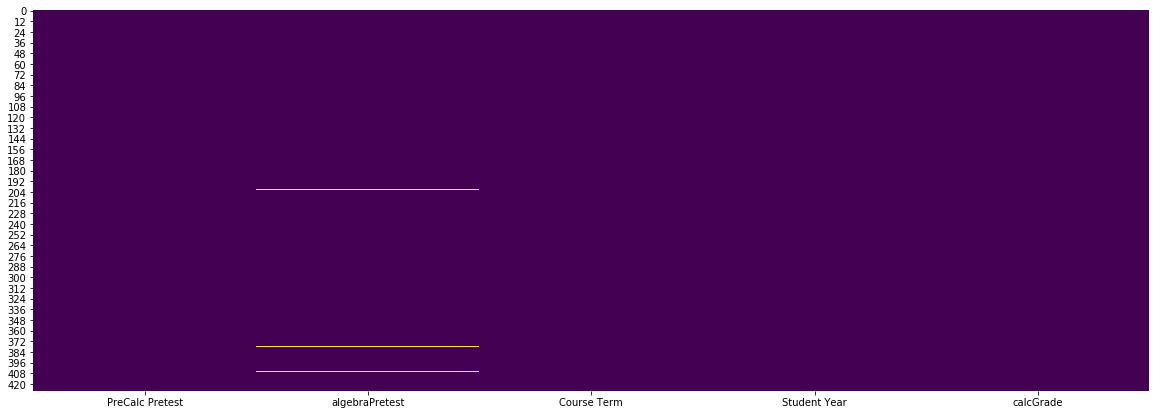

In [11]:
plt.figure(figsize=(20,7))
# yellow represents all the NULL rows in DataFrame
sns.heatmap(df.isnull(), cmap = 'viridis', cbar = False)

##### As there are only a few missing rows in the Algebra Pretest, we will replace those missing values with the average score for algebra Pretest. This way we can have more data to train a machine learning model to get a prediction.

In [12]:
df['algebraPretest'].mean()

84.05882352941177

### Now this is tricky. As shown above, the average score for algebra pretest is 84, however, student who have a higher average in algebra pre-test also end up getting a better Calc grade. Whereas students who get a lower average on pre-test end up getting a lower Calc grade.

* Lets visualize the average scores in algebra pre-test and compare it to the actual Calc grade.

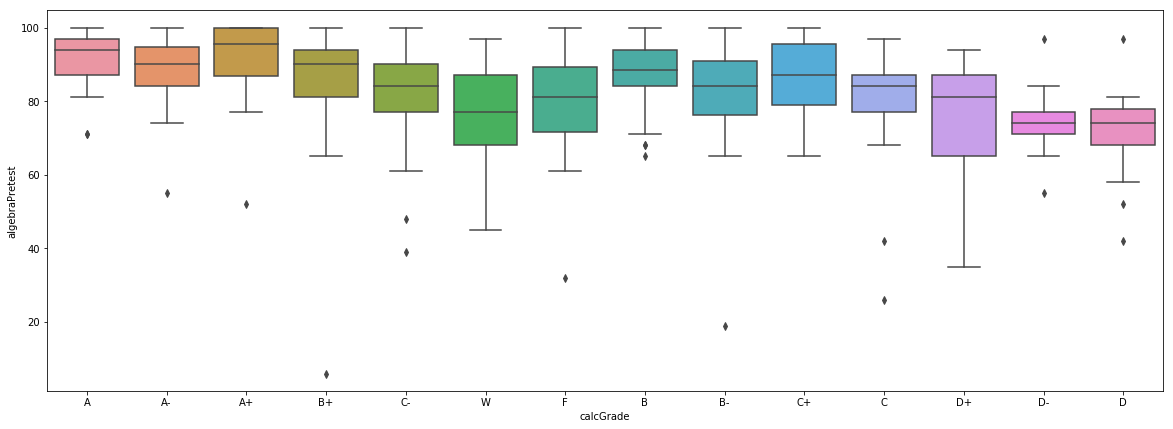

In [13]:
plt.figure(figsize=(20,7))
sns.boxplot(x='calcGrade', y = 'algebraPretest', data = df) 

* As shown on the box plot above, the average calc grade is higher for students with the score they get in algebra pretest. 

* Hence to fill in the missing value, we must compare the final Calc grade of the particular student and assign them the average score for algebra pretest.

#### The following three rows are to be filled with the mean scores of Algebra Pretest for the student's Calc Grade respectively

In [14]:
df[df['algebraPretest'].isnull() == True]

,PreCalc Pretest,algebraPretest,Course Term,Student Year,calcGrade
202,75.0,NaN,16/FA,FR,B
378,43.0,NaN,14/FA,SO,W
406,29.0,NaN,16/FA,FR,F


#### The goal now would be to get the average grades for the respective Calc Grade

In [15]:
df[df['calcGrade'] == 'B']['algebraPretest'].mean()

87.38888888888889

In [16]:
df[df['calcGrade'] == 'W']['algebraPretest'].mean()

76.2

In [17]:
df[df['calcGrade'] == 'F']['algebraPretest'].mean()

79.88461538461539

#### We will replace the null values with the averages calculated for the respective Calc grade for students. 

In [18]:
def impute_grade(cols):
    algebraPretest = cols[0]
    calcGrade = cols[1]
    
    if pd.isnull(algebraPretest):
        
        if calcGrade == 'B':
            return df[df['calcGrade'] == 'B']['algebraPretest'].mean()
        elif calcGrade == 'W':
            return df[df['calcGrade'] == 'W']['algebraPretest'].mean()
        else:
            return df[df['calcGrade'] == 'F']['algebraPretest'].mean()
        
    else:
        return algebraPretest

* Applying this function to the dataframe.

In [19]:
df['algebraPretest'] = df[['algebraPretest','calcGrade']].apply(impute_grade, axis = 1)

### Checking the dataframe for any null value if it exists.

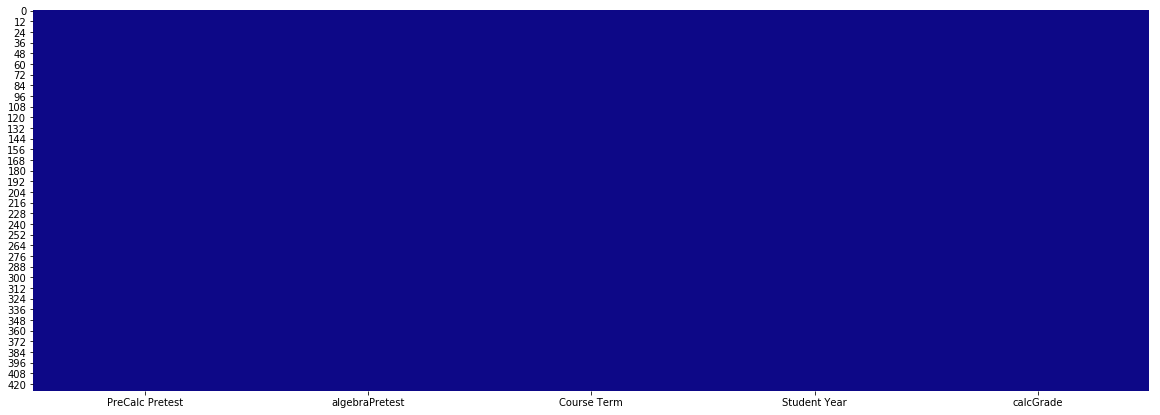

In [20]:
plt.figure(figsize=(20,7))
# yellow represents all the NULL rows in DataFrame
sns.heatmap(df.isnull(), cmap = 'plasma', cbar = False)

## Yes!! We finally got rid of all the null values, its time to focus on the machine learning aspect of this problem.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428 entries, 0 to 427
Data columns (total 5 columns):
PreCalc Pretest    428 non-null float64
algebraPretest     428 non-null float64
Course Term        428 non-null object
Student Year       428 non-null object
calcGrade          428 non-null object
dtypes: float64(2), object(3)
memory usage: 40.1+ KB


#### We have 428 values of PreCalc Pretest and Algebra Pretest to train out model on

In [22]:
df.head(3)

,PreCalc Pretest,algebraPretest,Course Term,Student Year,calcGrade
0,100.0,94.0,15/FA,SO,A
1,100.0,87.0,15/FA,SO,A-
2,100.0,90.0,15/SP,FR,A+


* As the machine learning model cannot process strings in the input, its best to drop columns with string on it. 
<br>
* We will drop columns Course terms and Student Year from the dataframe to train the model for our machine learning problem.

In [23]:
df.drop(['Course Term', 'Student Year'], axis=1, inplace = True)

In [24]:
df.head()

,PreCalc Pretest,algebraPretest,calcGrade
0,100.0,94.0,A
1,100.0,87.0,A-
2,100.0,90.0,A+
3,100.0,100.0,A
4,100.0,97.0,A


* Manipulating calc grade based on DFW, this way we can split the column that we want to predict in 2 parts. Students under DFW category and students under non-DFW

In [25]:
def impute_calcGrade(col):
    ns = 'non-DFW' # string variables
    s = 'DFW'      # string variables
    calcGrade = col[0]
    
    if calcGrade == 'A':
        return ns
    elif calcGrade == 'A+':
        return ns
    elif calcGrade == 'A-':
        return ns
    elif calcGrade == 'B+':
        return ns
    elif calcGrade == 'B':
        return ns
    elif calcGrade == 'B-':
        return ns
    elif calcGrade == 'C+':
        return ns
    elif calcGrade == 'C':
        return ns
    elif calcGrade == 'C-':
        return ns
    elif calcGrade == 'D+':
        return s
    elif calcGrade == 'D':
        return s
    elif calcGrade == 'D-':
        return s
    elif calcGrade == 'F':
        return s
    else:
        return s

In [26]:
df['calcGrade'] = df[['calcGrade']].apply(impute_calcGrade, axis = 1)

* Lets make sure the column calcGrade got updated!

In [27]:
df.tail()

,PreCalc Pretest,algebraPretest,calcGrade
423,14.0,81.0,non-DFW
424,14.0,68.0,DFW
425,7.0,19.0,non-DFW
426,7.0,74.0,DFW
427,4.0,65.0,DFW


#### Visualizing how seperable the data is

C:\Users\asus\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


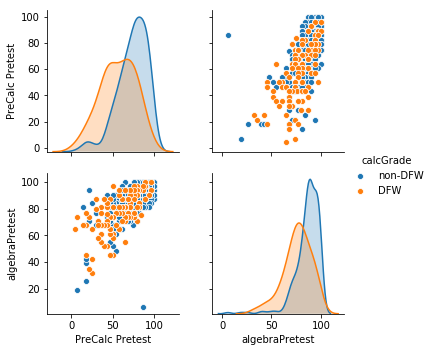

In [28]:
sns.pairplot(df,hue = 'calcGrade')

#### Splitting the model into train and test data using sklearn library

In [29]:
from sklearn.model_selection import train_test_split

* Selecting our X (Values that are used for prediction) and y (category that we want to predict)

In [30]:
X = df.drop('calcGrade', axis = 1)
y = df['calcGrade']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state = 4) 
#test_size = 0.35 and random_state = 0.4 gives the best accuracy 

### Using a logistic Regression model to determine the probability

In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
logmodel = LogisticRegression()

In [34]:
logmodel.fit(X_train,y_train);

In [35]:
predictions = logmodel.predict(X_test)

#### Checking the performance of the model

In [36]:
from sklearn.metrics import classification_report, confusion_matrix 

In [37]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

        DFW       0.64      0.29      0.40        31
    non-DFW       0.84      0.96      0.89       119

avg / total       0.80      0.82      0.79       150



* We get an ok-ish accuracy

In [38]:
# True positive, True negative, False positive and False Negative
print(confusion_matrix(y_test,predictions))

[[  9  22]
 [  5 114]]


* Given a student's pre-calc and algebra test score, there is an 80% chance of predicting if the student will fall under DFW category or not.

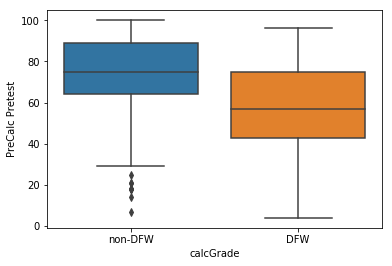

In [39]:
sns.boxplot(x = 'calcGrade',y='PreCalc Pretest',data = df)

In [40]:
df[df['calcGrade'] == 'non-DFW']['PreCalc Pretest'].mean()

73.63949843260188

* Student's who score around 73.63 on their Pre-Calc Pretest have a 84% (from the classification report) chance of not falling under DFW.

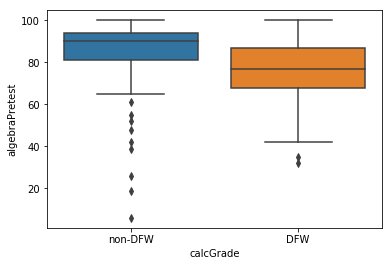

In [41]:
sns.boxplot(x = 'calcGrade',y='algebraPretest',data = df)

In [42]:
df[df['calcGrade'] == 'non-DFW']['algebraPretest'].mean()

86.69400905607803

* Student's who score around 86.694 on their Pre-Calc Pretest have a 84% (from the classification report) chance of not falling under DFW. 

In the end it all comes down to student's motivation to do well or not in college. I personally had scored around 95 on both my algebra and precalc pretest, however, I got a D+ in the first Calc course I took at Washington College. This was mostly because I wasn't sure of what I wanted to do and did not have any motivation to care about my grades. If students perform well in Pre-calc and algebra pretest and if they have decent high school grades in math, it would mean that student is motivated and would do well in college. The best predictor of a student's grade would be their past grades in the same/related course they have taken in the past. 

### Citations-
<br>
drop columns from pandas dataframe - http://cmdlinetips.com/2018/04/how-to-drop-one-or-more-columns-in-pandas-dataframe/ 
<br>
using heatmap to visuzlize null values - https://dev.to/tomoyukiaota/visualizing-the-patterns-of-missing-value-occurrence-with-python-46dj 
<br>
using boxplot using seaborn - https://seaborn.pydata.org/generated/seaborn.boxplot.html 
<br>
using swarmplot using seaborn - https://seaborn.pydata.org/generated/seaborn.swarmplot.html 